In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# 1. Introduction of Times series

A time series model often forecasts based on the assumption that past patterns will repeat in the future. Therefore, when building a time series model, we are modeling the past relationship between the independent variable (input variable) and the dependent variable (target variable). Based on this relationship, predict the future value of the dependent variable. 

Some common characteristics of time series data include **Seasonality** (Seasonality refers to patterns that repeat at regular intervals over time) and **Trend** (A trend represents the long-term movement or directionality in the data).

Some popular models: **ARIMA model** (Based on the hypothesis of stationary series and constant error variance. The model uses past data to predict the future) and **SARIMA model** (This is essentially the ARIMA model but is specially adapted to apply to time series with seasonal factors).  

# 2. ARIMA model

## 2.1 ARIMA model theory

The model will represent the multiple linear regression equation of the input variables (called independent variables) as 2 main components:

- **Auto regression AR**: $AR(p) = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} $

- **Moving average MA**: $MA(q) = \mu + \theta_0 + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ...+ \theta_q \epsilon_{t-q}$

   It find the linear relationship between stochastic term $\epsilon_t \sim WN(0, \sigma^2)$, statisfies:
$$
\begin{cases}
    E(\epsilon_t) & = 0 \\
    \sigma(\epsilon_t) & = \alpha \\
    \rho(\epsilon_t, \epsilon_{t-s}) & = 0, \forall s \leq t
\end{cases}.
$$ 

- **Intergrated**: to apply ARIMA, we should ensure that our data is stationary. If it is not stationary, the simplest method is to take the difference. Integrated of order $d$: 
      $I(1) = \Delta (x_t) = x_t - x_{t-1} \implies I(d) = \Delta (x_t) = \Delta (\Delta (\Delta (... \Delta (x_t))))$
      
Therefore, ARIMA($p,d,q$): $\Delta x_t = \phi_1 \Delta x_{t-1} + \phi_2 \Delta x_{t-2} + ... + \phi_p \Delta x_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ...+ \theta_q \epsilon_{t-q}$

## 2.2 Aplication

In [87]:
files = ["MSN.csv","PNJ.csv","FPT.csv","VIC.csv"]
variables = ["MSN", "PNJ", "FPT", "VIC"]

for file, var in zip(files, variables):
    globals()[var] = pd.read_csv(file)

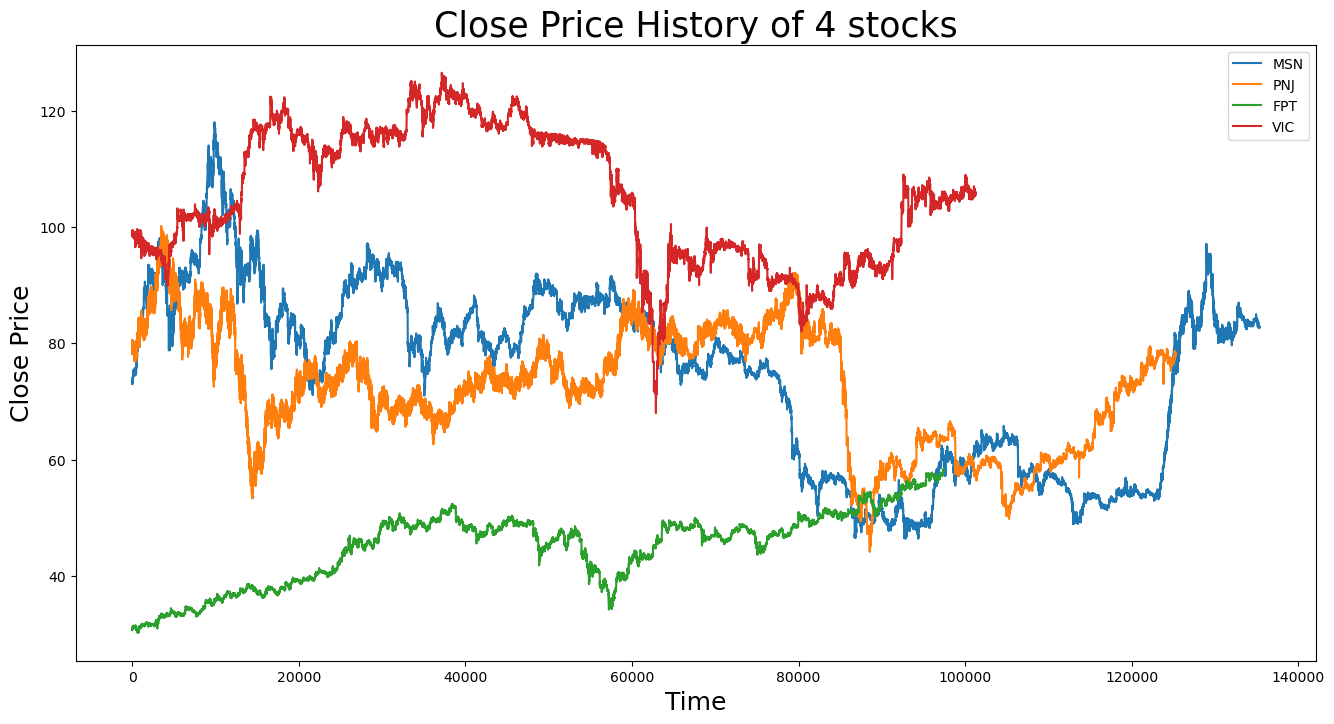

In [88]:
plt.figure(figsize = (16,8))
plt.title("Close Price History of 4 stocks", fontsize = 25)

for var in variables:
    plt.plot(globals()[var]['Close'], label = var)
    
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Close Price', fontsize = 18)
plt.legend()
plt.show()

In [89]:
for var in variables:
    globals()[var] = globals()[var]['Close']

### 2.2.1 Step 1: Create log return series and survey data 

To facilitate the construction of the ARIMA model, we will convert the close price series to stationary by $r_t = \log{(\frac{x_t}{x_{t-1}})}$ (log return).

Now, the goal of model will be $r_t$. After that, we can convert it back easily.

In [90]:
for var in variables:
    globals()[var + "_log_return"] = np.log(globals()[var] / globals()[var].shift(1))
    print(f"{var} : {globals()[var + '_log_return'][:3]}")

MSN : 0         NaN
1   -0.001369
2    0.006826
Name: Close, dtype: float64
PNJ : 0         NaN
1   -0.000633
2   -0.010186
Name: Close, dtype: float64
FPT : 0         NaN
1   -0.002593
2   -0.002275
Name: Close, dtype: float64
VIC : 0         NaN
1    0.000000
2    0.001015
Name: Close, dtype: float64


In [91]:
for var in variables:
    globals()[var + "_mean"] = np.nanmean(globals()[var + "_log_return"])
    globals()[var + "_log_return"][0] = globals()[var + "_mean"]
    print(f"{var} log return: {globals()[var + '_log_return'][:2]}")

MSN log return: 0    9.205536e-07
1   -1.368926e-03
Name: Close, dtype: float64
PNJ log return: 0   -7.001675e-08
1   -6.331919e-04
Name: Close, dtype: float64
FPT log return: 0    0.000006
1   -0.002593
Name: Close, dtype: float64
VIC log return: 0    6.966706e-07
1    0.000000e+00
Name: Close, dtype: float64


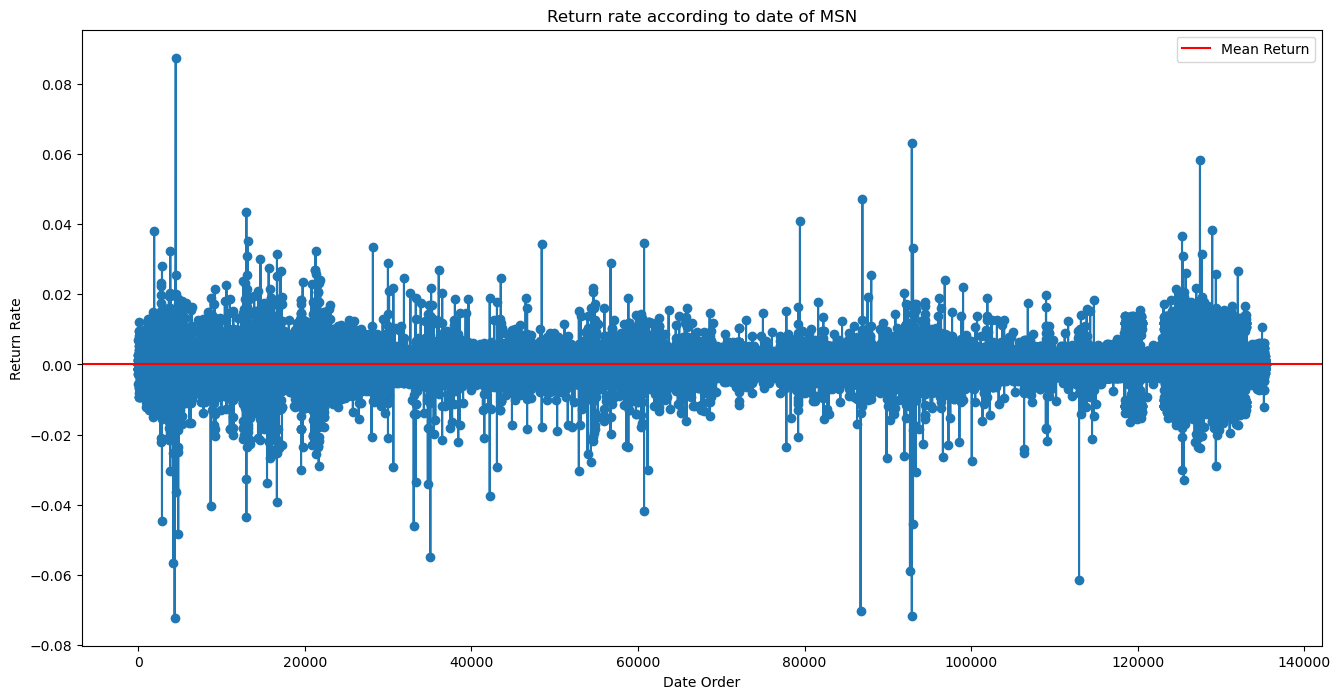

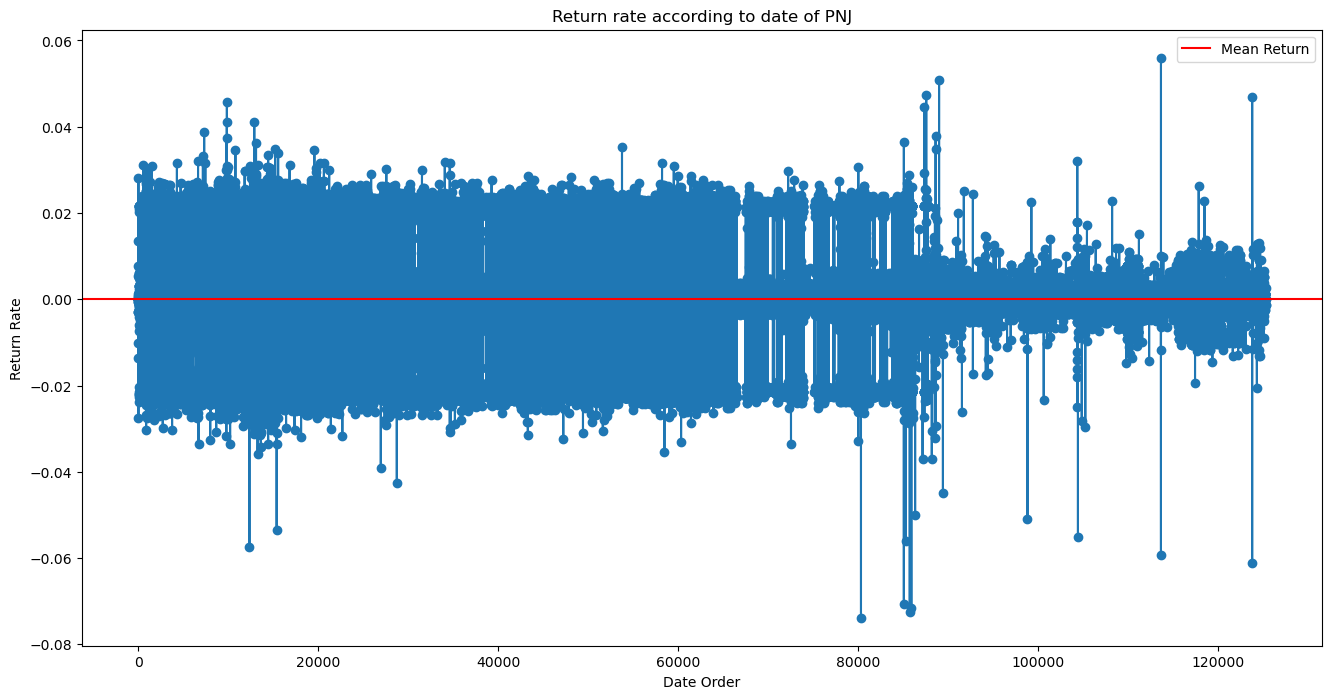

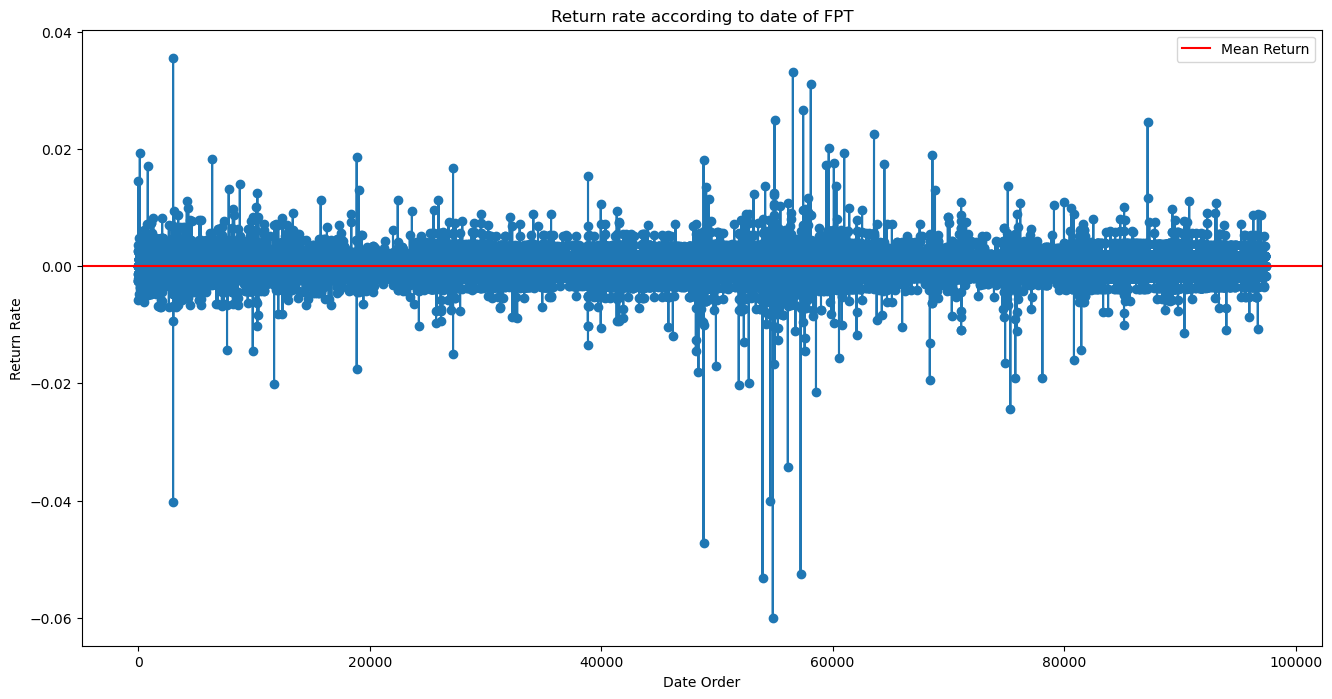

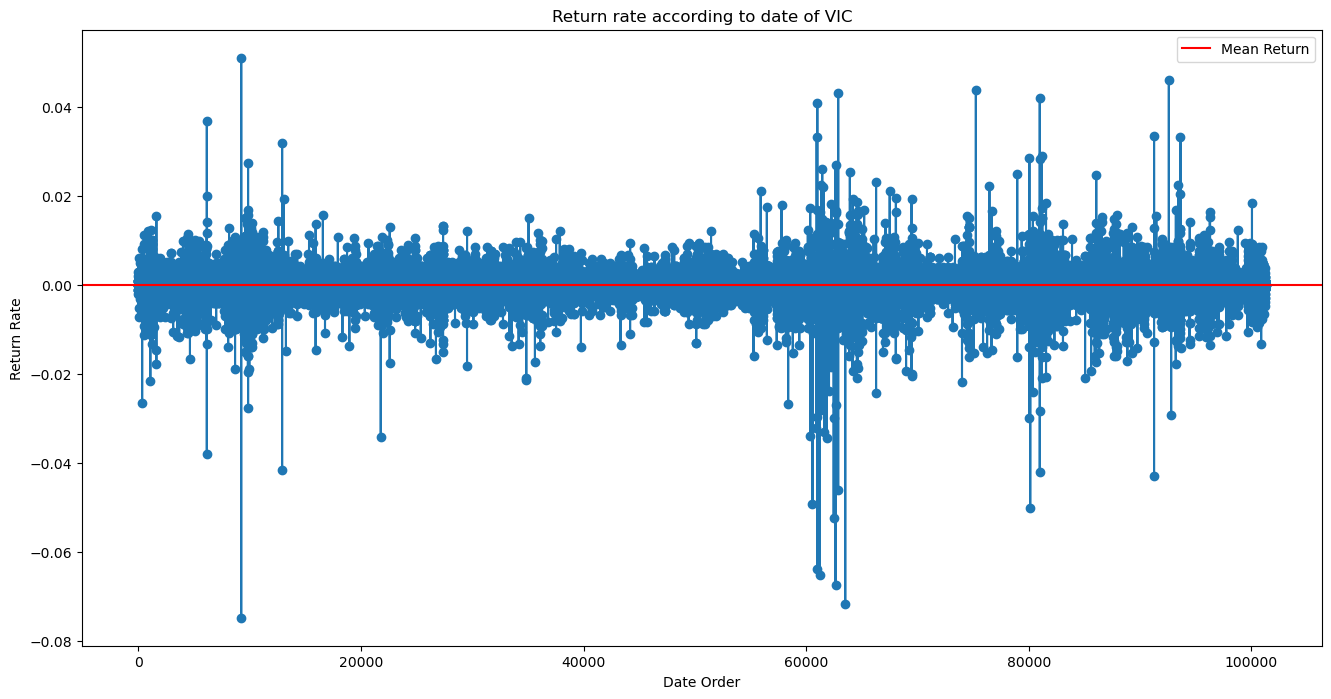

In [94]:
for var in variables:
    plt.figure(figsize = (16,8))
    plt.plot(np.arange(globals()[var + "_log_return"].shape[0]), globals()[var + "_log_return"], '-o')
    plt.axhline(y = globals()[var + "_mean"], label = "Mean Return", c = 'red')
    plt.title(f"Return rate according to date of {var}")
    plt.xlabel("Date Order")
    plt.ylabel("Return Rate")
    plt.legend()
    plt.show()

A graph of the return series shows it to be a white-noise random movement, with a near-zero mean and constant variance.

**Linear relationship betweeen $x_t$ and $x_{t-1}$**

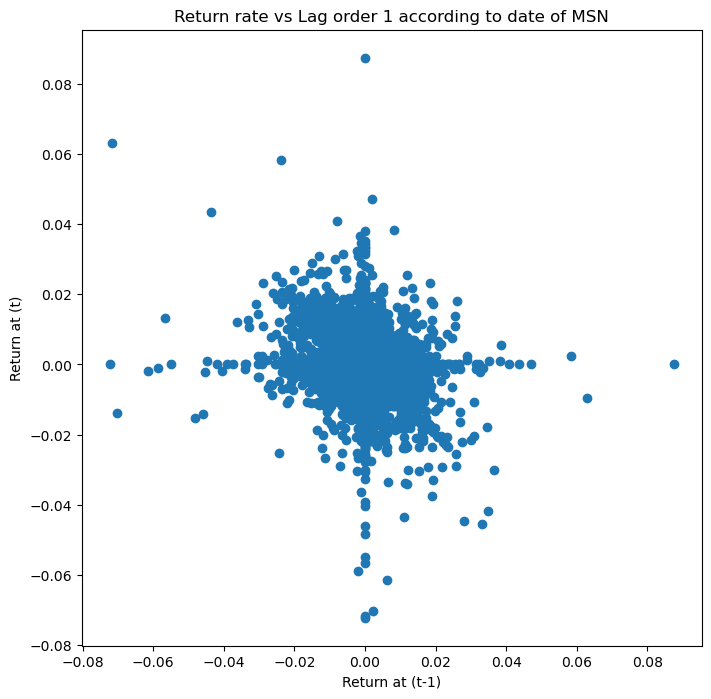

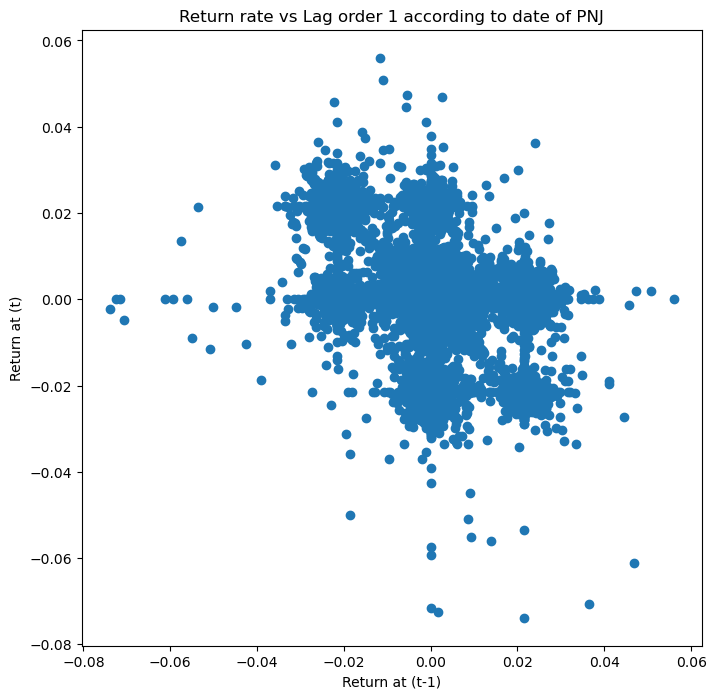

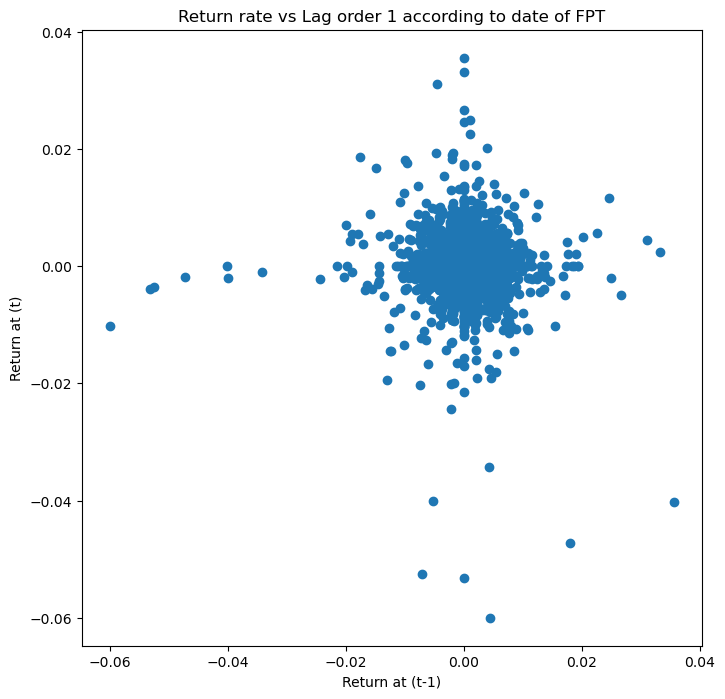

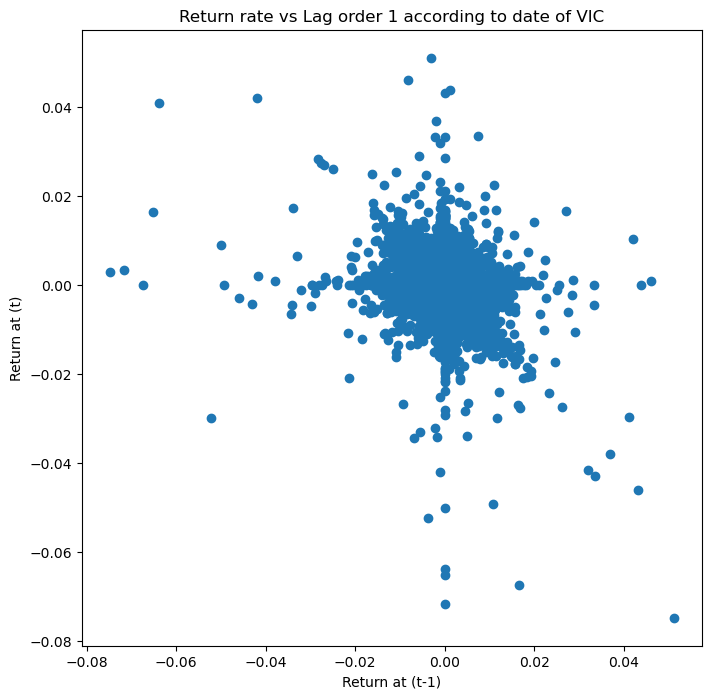

In [95]:
for var in variables:
    plt.figure(figsize = (8,8))
    plt.scatter(x = globals()[var + "_log_return"][1:], y = globals()[var + "_log_return"][:-1])
    plt.title(f"Return rate vs Lag order 1 according to date of {var}")
    plt.xlabel("Return at (t-1)")
    plt.ylabel("Return at (t)")
    plt.show()

The graph shows two series and no correlation. Their chart is a collection of points that do not follow a specific trend.

**Probability distribution**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24744\279817486.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(globals()[var + "_log_return"], bins = 20)
C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24744\279817486.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function 

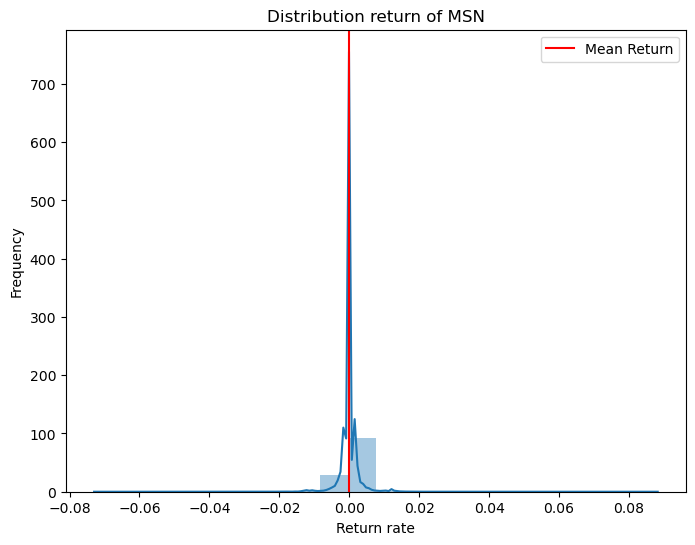

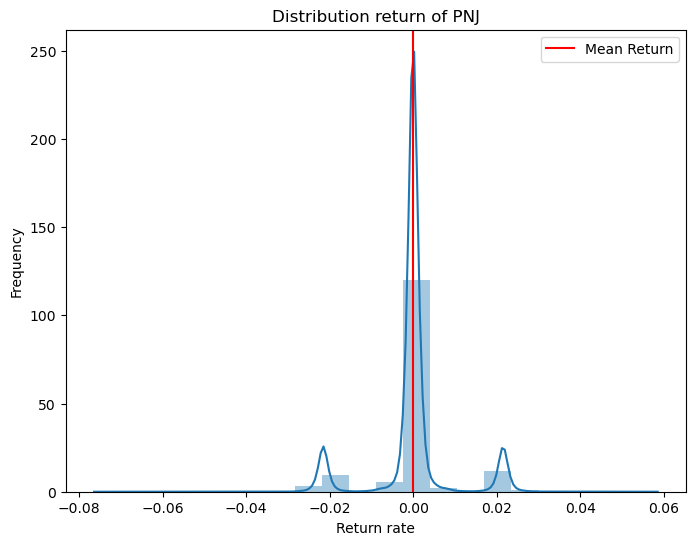

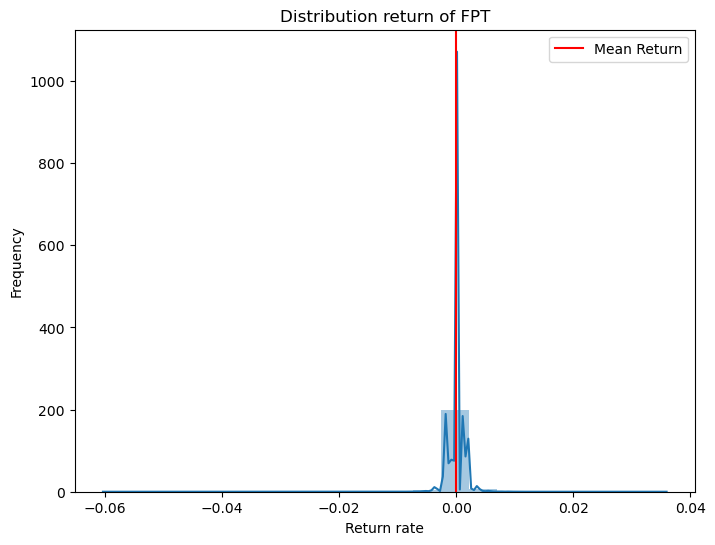

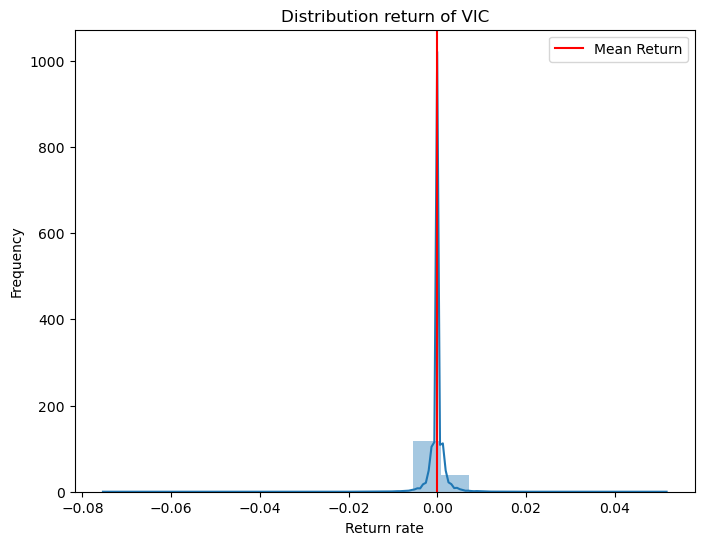

In [96]:
for var in variables:
    plt.figure(figsize = (8,6))
    sns.distplot(globals()[var + "_log_return"], bins = 20)
    plt.axvline(x = globals()[var + "_mean"], label = 'Mean Return', c = 'red')
    plt.title(f"Distribution return of {var}")
    plt.legend()
    plt.xlabel("Return rate")
    plt.ylabel('Frequency')

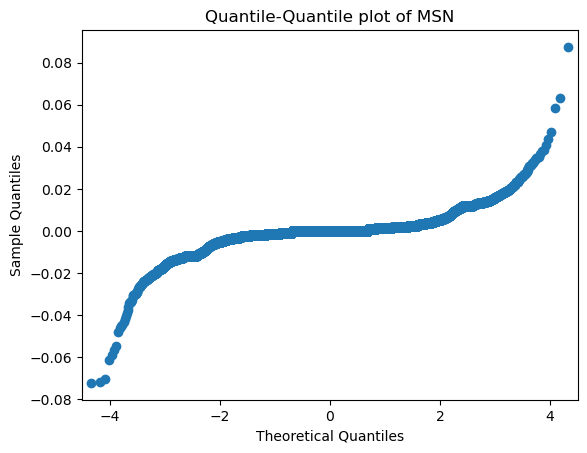

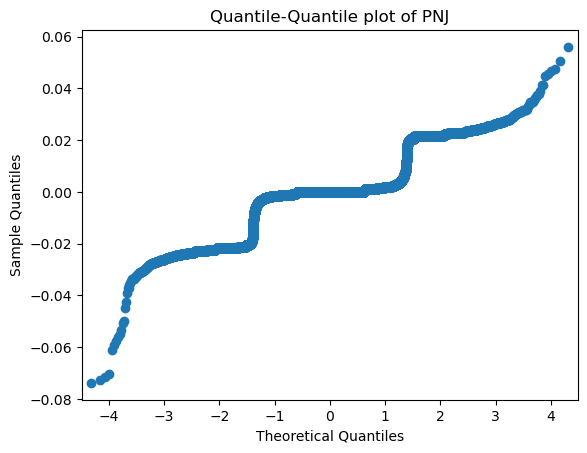

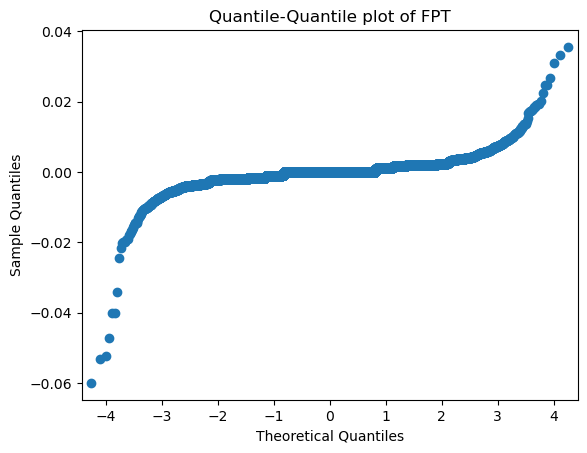

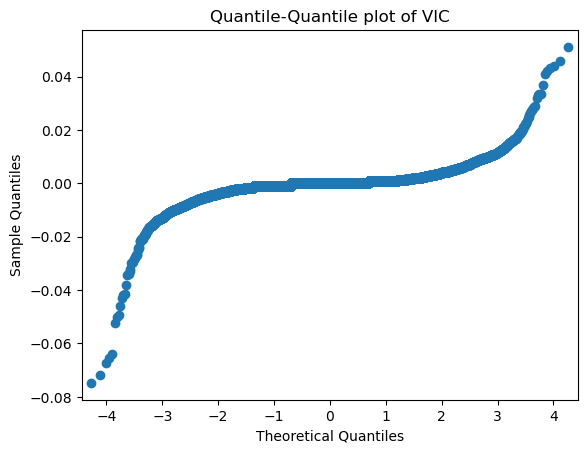

In [97]:
for var in variables:
    sm.qqplot(globals()[var + "_log_return"])
    plt.title(f"Quantile-Quantile plot of {var}")
    plt.show()

### 2.2.2 Step 2: Split data into Train and Test 

In [101]:
for var in variables:
    globals()[var + "_msk"] = (globals()[var + "_log_return"].index < len(globals()[var + "_log_return"]) - 10)
    globals()[var + "_train"] = globals()[var + "_log_return"][globals()[var + "_msk"]].copy()
    globals()[var + "_test"] = globals()[var + "_log_return"][~ globals()[var + "_msk"]].copy()
    print(f"{var}: {globals()[var + '_test']}")

MSN: 135344    0.000000
135345    0.002415
135346   -0.002415
135347    0.001208
135348    0.000000
135349    0.000000
135350    0.000000
135351    0.000000
135352    0.000000
135353    0.000000
Name: Close, dtype: float64
PNJ: 125299    0.000000
125300    0.000000
125301    0.000000
125302    0.001278
125303    0.000000
125304   -0.001278
125305    0.000000
125306    0.000000
125307   -0.001280
125308    0.002558
Name: Close, dtype: float64
FPT: 97396    0.00000
97397    0.00000
97398    0.00000
97399    0.00000
97400    0.00172
97401    0.00000
97402    0.00000
97403    0.00000
97404   -0.00172
97405    0.00000
Name: Close, dtype: float64
VIC: 101256    0.000000
101257    0.000000
101258    0.000000
101259    0.000000
101260    0.000000
101261   -0.000946
101262    0.000000
101263    0.000000
101264    0.000000
101265    0.000000
Name: Close, dtype: float64


### 2.2.3 Step 3: Check for stationarity of time series

**Using Argument Dickey Fuller (ADF)**

We have: 

- The series has a intercept and has a trend: $AR(1): y_t = \alpha + \phi y_{t-1} + \epsilon_t$.

- The series has no intercept and has a trend: $AR(1): y_t = \phi y_{t-1} + \epsilon_t$.

- The series has a intercept and has no trend: $AR(1): y_t = \alpha + \epsilon_t$.

Then, $y_t = \phi y_{t-1} + \epsilon_t = \phi (\phi y_{t-2} + \epsilon_{t-1}) + \epsilon_t = ... = \phi^t y_0 + \phi^{t-1} \epsilon_1 + ... + \phi \epsilon_{t-1} + \epsilon_t$.

Therefore, $E(y_t) = \phi^t E(y_0) + E(\phi^{t-1} \epsilon_1 + ... + \phi \epsilon_{t-1} + \epsilon_t) = \phi^t E(y_0)$, since ($\epsilon_t \sim WN(0,\sigma^2)$). We obtain:
$$
\begin{cases}
    \phi > 1 &: \lim_{t \to \infty} \phi^t E(y_0) = \infty \\
    \phi = 1 &: \lim_{t \to \infty} \phi^t E(y_0) = E(y_0) \\
    \phi < 1 &: \lim_{t \to \infty} \phi^t E(y_0) = 0
\end{cases}.
$$ 
Hypothesis Testing: $$
\begin{cases}
    H_0: \phi = 1 & \implies Unit root, non-stationary \\
    H_1: |\phi| < 1 & \implies non-unit root, stationary \\
\end{cases}.
$$  
$DF = \frac{\hat{\phi -1}}{SE(\hat{\hat{\phi}})}$

Note: p-value < 0.05 (reasonable significance level) $\implies$ Reject $H_0$

In [102]:
for var in variables:
    globals()[var + "_result"] = adfuller(globals()[var + "_train"])
    print(f"{var}")
    print('ADF Statistic: %f' % globals()[var + "_result"][0])
    print('p-value: %f' % globals()[var + "_result"][1])
    print('Critical Values: ')
    for key, value in globals()[var + "_result"][4].items():
        print('\t%s: %.3f' % (key, value))
        

MSN
ADF Statistic: -42.258826
p-value: 0.000000
Critical Values: 
	1%: -3.430
	5%: -2.862
	10%: -2.567
PNJ
ADF Statistic: -61.753778
p-value: 0.000000
Critical Values: 
	1%: -3.430
	5%: -2.862
	10%: -2.567
FPT
ADF Statistic: -62.991839
p-value: 0.000000
Critical Values: 
	1%: -3.430
	5%: -2.862
	10%: -2.567
VIC
ADF Statistic: -42.735519
p-value: 0.000000
Critical Values: 
	1%: -3.430
	5%: -2.862
	10%: -2.567


All the p-value < 0.05. Then, all series are stationary.

### 2.2.4 Step 4: Build the model

#### Step 4a. Choose p, d by ACF and PACF

**ACF - AutoCorrelation Function**: Time series will be correlated with their lagged values and the closer the values are to each other, the stronger the correlation or the values belonging to the same period of the series will be highly correlated. **Using to find MA(q)**. 

We have: $\rho(s,t) = \frac{cov(x_s,x_t)}{\sqrt{\sigma_s \sigma_t}}$. 

Where, $\rho(s,t)$: measure the predictive ability of variable $x_t$ if only variable $x_s$

The perfect correlation:  $\rho(s,t) = \pm 1 \implies x_t = \beta_0 + \beta_1 x_s$ 
$$
\begin{cases}
    \rho(s,t) = 1 & \implies \beta_1 > 0 \\
    \rho(s,t) = -1 & \implies \beta_1 < 0 \\
\end{cases}.
$$  

Hypothesis Testing:
$H_0$: true value of the autocorrelation coefficient at lag $s$ is zero $\implies$ a 95% confidence interval is ($\pm 1.96 \times \frac{1}{\sqrt{T}}$).

**PACF - Partitial AutoCorrelation Function**: This correlation coefficient eliminates the influence of intermediate lag sequences (It is $x_{t-1}, ..., x_{t-k+1}$ between $x_t$ and $x_{t-k}$).

The generalized linear regression equation $x_t$: $x_t = \epsilon_t + \alpha_0 + \alpha_1 x_{t-1} + ... + \alpha_k x_{t-k}$

Estimated value of the model $x_t$: $P_{t,k}(x_t) = \alpha_0 + \alpha_1 x_{t-1} + ... + \alpha_k x_{t-k}$

Therefore, $\phi_k = corr(x_t - P_{t,k}(x_t), x_{t-k} - P_{t,k}(x_{t-k}))$


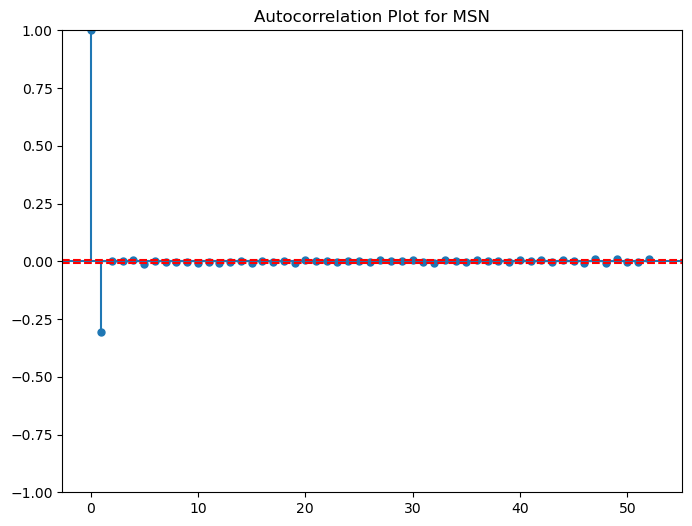

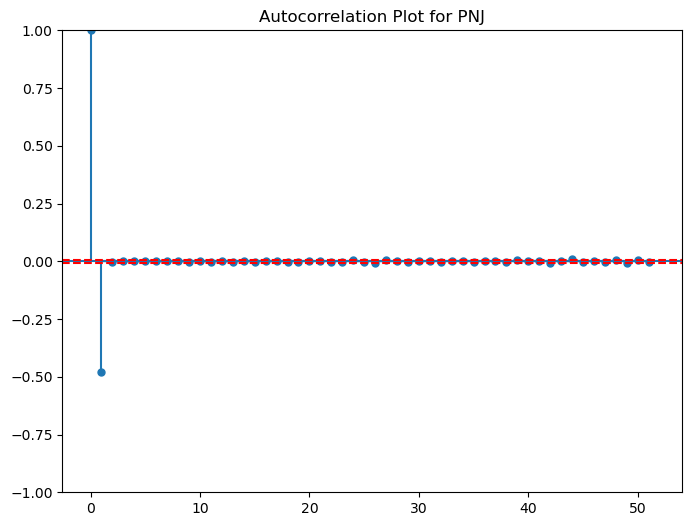

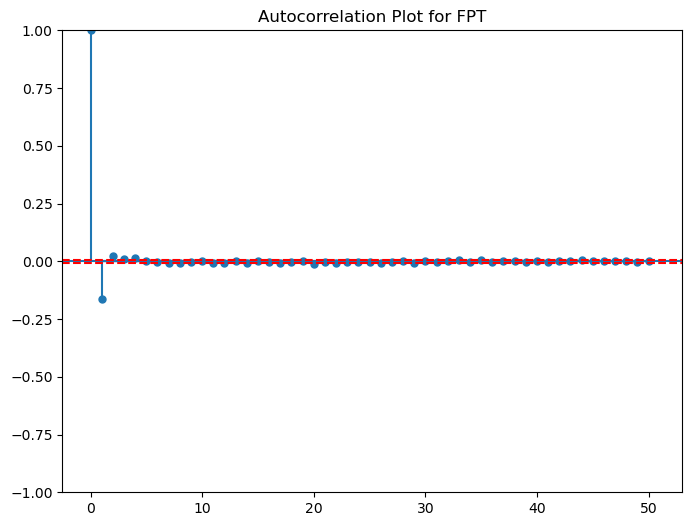

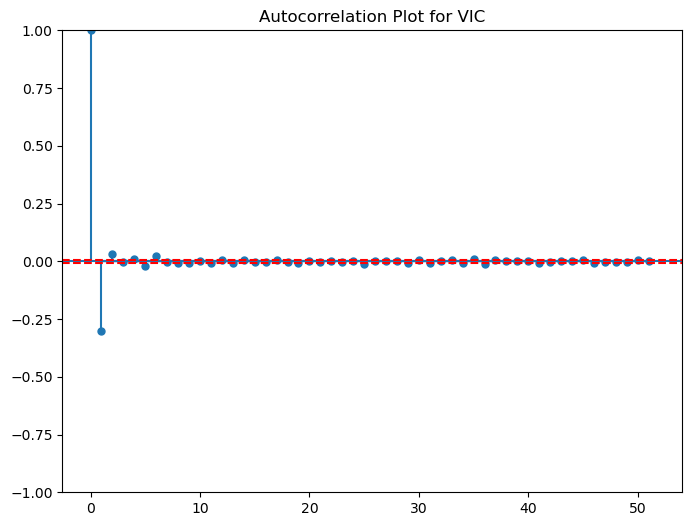

In [103]:
for var in variables:
    fig, ax = plt.subplots(figsize = (8,6))
    plot_acf(globals()[var + "_train"], ax = ax)
    ax.axhline(y = 1.96/ np.sqrt(len(globals()[var + "_train"])), linestyle = "--", color = "red")
    ax.axhline(y = - 1.96/ np.sqrt(len(globals()[var + "_train"])), linestyle = "--", color = "red")
    plt.title(f"Autocorrelation Plot for {var}")
    plt.show()

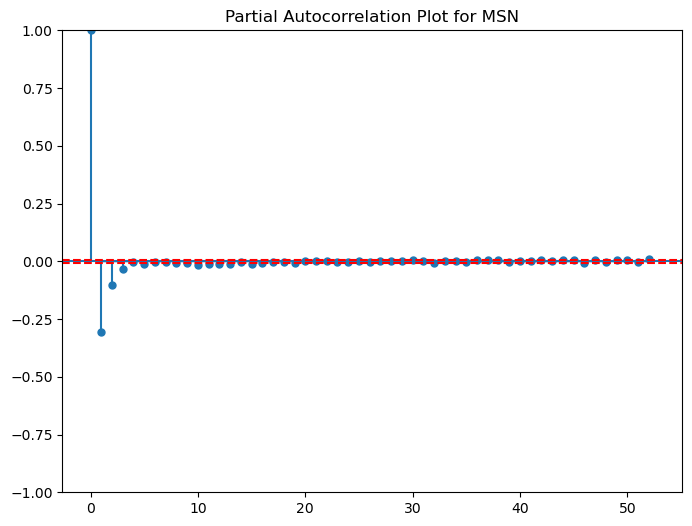

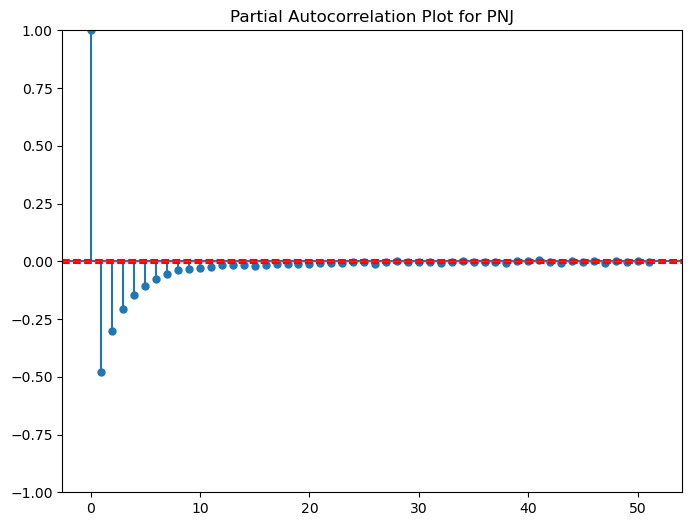

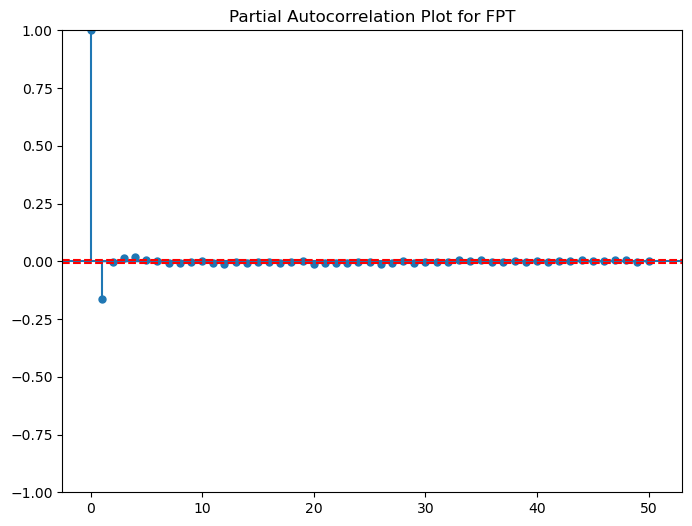

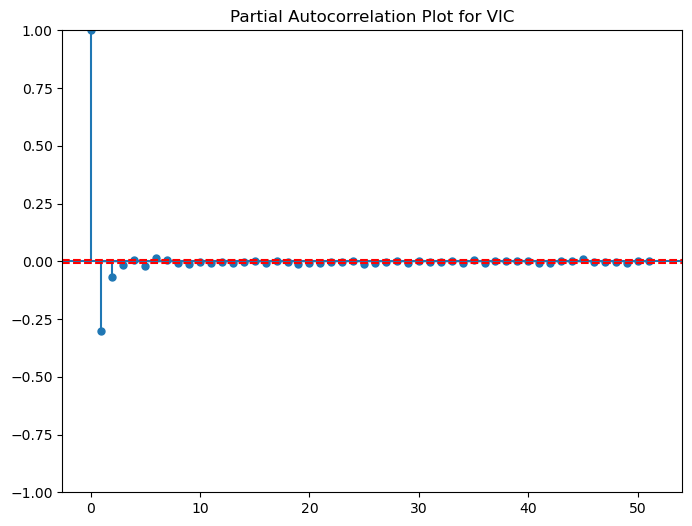

In [104]:
for var in variables:
    fig, ax = plt.subplots(figsize = (8,6))
    plot_pacf(globals()[var + "_train"], ax = ax)
    ax.axhline(y = 1.96/ np.sqrt(len(globals()[var + "_train"])), linestyle = "--", color = "red")
    ax.axhline(y = - 1.96/ np.sqrt(len(globals()[var + "_train"])), linestyle = "--", color = "red")
    plt.title(f"Partial Autocorrelation Plot for {var}")
    plt.show()

**Summary of the Behaviour of the ACF for AR and MA processes**

An autoregressive process AR($p$) has

- a geometrically decaying ACF

- number of non-zero points of PACF = AR order = $p$

A moving average process MA($q$) has

- Number of non-zero points of ACF = MA order = $q$

- a geometrically decaying PACF

ARMA models have both ACF and PACF geometrically decaying to 0.

Therefore, I choose that MSN: ARIMA(3,0,1), PNJ: ARIMA(9,0,1), FPT: ARIMA(1,0,1), VIC: ARIMA(4,0,4)

In [105]:
orders = {'MSN': (3,0,1), 'PNJ': (9,0,1), 'FPT': (1,0,1), 'VIC': (4,0,4)}
for var in variables:
    order = orders[var]
    globals()[var + "_model_arima"] = ARIMA(globals()[var + "_train"], order = order)
    globals()[var + "_model_fit"] = globals()[var + "_model_arima"].fit()
    print(f"{var}: {globals()[var + '_model_fit'].summary()}")

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MSN:                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:               135344
Model:                 ARIMA(3, 0, 1)   Log Likelihood              606796.820
Date:                Fri, 15 Mar 2024   AIC                       -1213581.640
Time:                        14:03:45   BIC                       -1213522.747
Sample:                             0   HQIC                      -1213564.007
                             - 135344                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.504e-06   7.46e-06     -0.335      0.737   -1.71e-05    1.21e-05
ar.L1      -2.306e-06      0.000     -0.005      0.996      -0.001       0.001
ar.L2       8.138e-09      0.001   6.37e-06    

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


FPT:                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                97396
Model:                 ARIMA(1, 0, 1)   Log Likelihood              502008.167
Date:                Fri, 15 Mar 2024   AIC                       -1004008.334
Time:                        14:11:02   BIC                       -1003970.388
Sample:                             0   HQIC                      -1003996.805
                              - 97396                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.486e-06   3.93e-06      1.650      0.099   -1.22e-06    1.42e-05
ar.L1         -0.1474      0.010    -14.386      0.000      -0.167      -0.127
ma.L1         -0.0171      0.010     -1.682    

#### Step 4b. Another Option to find p, q: Auto ARIMA

**Using AIC - Akaike Information Criteria**

When a statistical model is used for forecasting, the results will almost never be completely accurate. Therefore, some information will be lost because it cannot be predicted from the model. AIC estimates the relative amount of information lost by a given model: **The smaller the AIC, the better our model fits.**

Let $\hat{L}$ is maximum likelihood function and $k$ is number of estimator parameters: $AIC = 2k - 2 \ln(\hat{L})$.

In [110]:
for var in variables:
    globals()[var + "_auto_arima"] = pm.auto_arima(globals()[var + "_train"], stepwise = False, seasonal = False)
    print(f"{var}: {globals()[var + '_auto_arima']}")

MSN:  ARIMA(0,0,5)(0,0,0)[0]          
PNJ:  ARIMA(0,0,5)(0,0,0)[0]          
FPT:  ARIMA(0,0,4)(0,0,0)[0]          
VIC:  ARIMA(5,0,0)(0,0,0)[0]          


In [111]:
for var in variables:
    print(f"{var}: {globals()[var + '_auto_arima'].summary()}")

MSN:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               135344
Model:               SARIMAX(0, 0, 5)   Log Likelihood              614348.265
Date:                Fri, 15 Mar 2024   AIC                       -1228684.531
Time:                        14:44:47   BIC                       -1228625.637
Sample:                             0   HQIC                      -1228666.898
                             - 135344                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3437      0.001   -446.904      0.000      -0.345      -0.342
ma.L2          0.0018      0.001      1.564      0.118      -0.000       0.004
ma.L3          0.0024      0.001      1.845    

### 2.2.5 Step 5: Fit the model

In [113]:
for var in variables:
    globals()[var + "_ACF/PACF_forecast_test"] = globals()[var + '_model_fit'].forecast(len(globals()[var + "_test"]))
    print(f"{var} forecast using ACF/PACF: {globals()[var + '_ACF/PACF_forecast_test']}")

MSN forecast using ACF/PACF: 135344   -0.000003
135345   -0.000003
135346   -0.000003
135347   -0.000003
135348   -0.000003
135349   -0.000003
135350   -0.000003
135351   -0.000003
135352   -0.000003
135353   -0.000003
Name: predicted_mean, dtype: float64
PNJ forecast using ACF/PACF: 125299    2.719859e-04
125300    7.372371e-07
125301    4.549211e-06
125302    2.465197e-06
125303   -3.668077e-06
125304   -2.542437e-05
125305   -9.719361e-06
125306   -9.988724e-06
125307   -3.887385e-06
125308   -3.519872e-06
Name: predicted_mean, dtype: float64
FPT forecast using ACF/PACF: 97396    0.000008
97397    0.000006
97398    0.000007
97399    0.000006
97400    0.000006
97401    0.000006
97402    0.000006
97403    0.000006
97404    0.000006
97405    0.000006
Name: predicted_mean, dtype: float64
VIC forecast using ACF/PACF: 101256    0.000334
101257   -0.000024
101258   -0.000020
101259   -0.000011
101260    0.000046
101261   -0.000024
101262   -0.000014
101263    0.000013
101264    0.000019
10

In [118]:
for var in variables:
    globals()[var + "_autoARIMA_forecast_test"] = globals()[var + "_auto_arima"].predict(len(globals()[var + "_test"]))
    print(f"{var} forecast using Auto ARIMA: {globals()[var + '_autoARIMA_forecast_test']}")

MSN forecast using Auto ARIMA: 135344    1.405179e-06
135345   -1.111631e-07
135346    4.725357e-08
135347    4.903069e-08
135348    3.336465e-08
135349    0.000000e+00
135350    0.000000e+00
135351    0.000000e+00
135352    0.000000e+00
135353    0.000000e+00
dtype: float64
PNJ forecast using Auto ARIMA: 125299    2.487246e-04
125300   -5.085997e-06
125301    3.473715e-07
125302    9.872967e-07
125303    1.141167e-06
125304    0.000000e+00
125305    0.000000e+00
125306    0.000000e+00
125307    0.000000e+00
125308    0.000000e+00
dtype: float64
FPT forecast using Auto ARIMA: 97396   -3.115743e-05
97397   -3.554186e-06
97398   -3.092685e-08
97399    3.103352e-07
97400    0.000000e+00
97401    0.000000e+00
97402    0.000000e+00
97403    0.000000e+00
97404    0.000000e+00
97405    0.000000e+00
dtype: float64
VIC forecast using Auto ARIMA: 101256    3.210601e-04
101257   -3.594514e-05
101258    3.910020e-06
101259   -3.405409e-06
101260    1.860323e-05
101261   -1.168487e-05
101262    3.1

### 2.2.6 Step 6: Predict the model

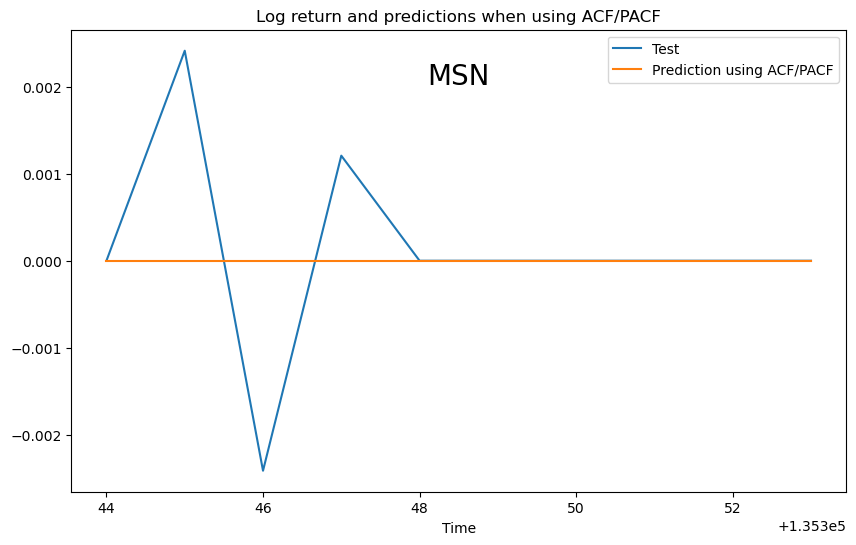

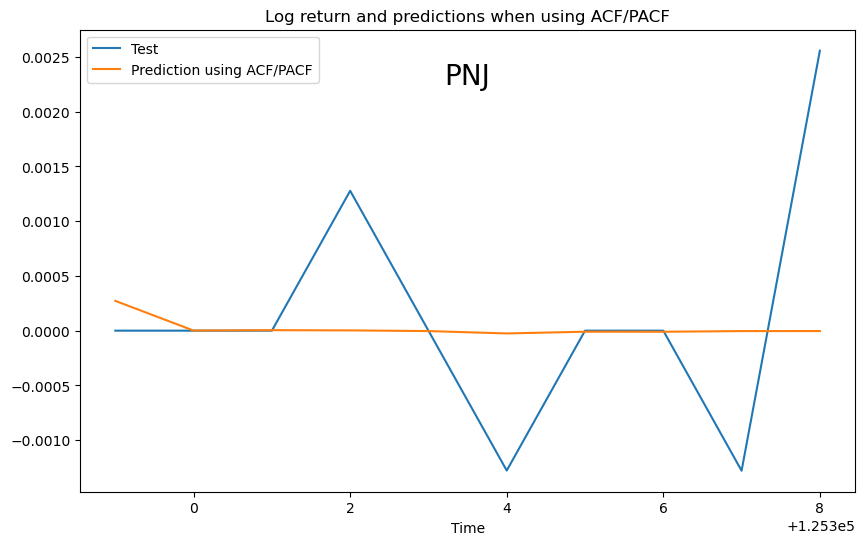

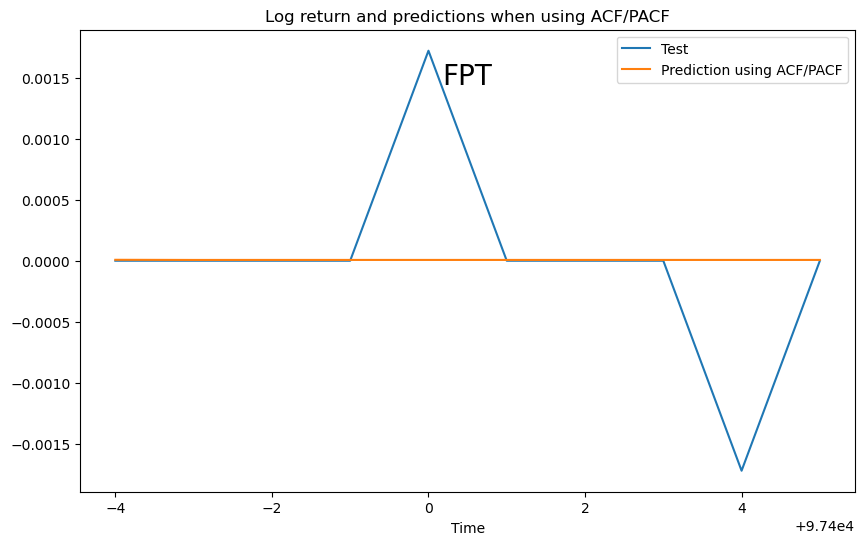

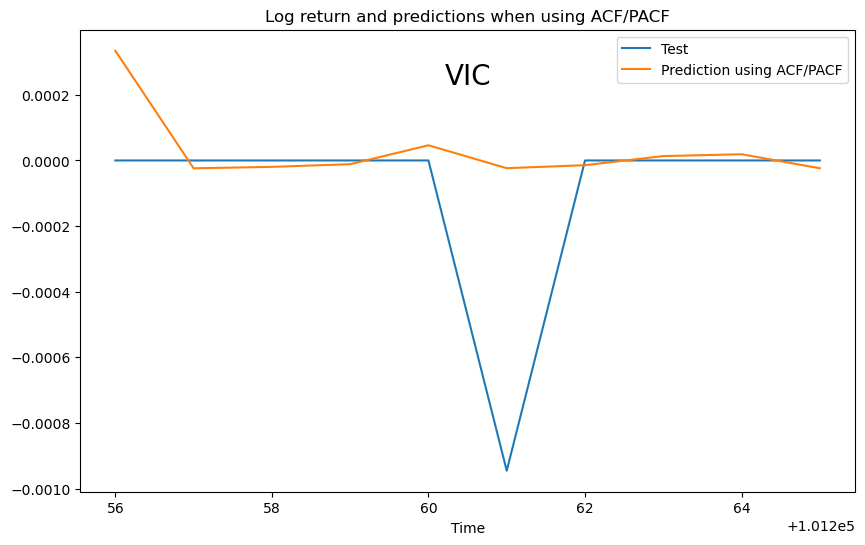

In [122]:
for var in variables:
    plt.figure(figsize = (10,6))
    plt.plot(globals()[var + "_test"].index, globals()[var + "_test"], label='Test')
    plt.plot(globals()[var + "_test"].index, globals()[var + '_ACF/PACF_forecast_test'], label = "Prediction using ACF/PACF")
    plt.title("Log return and predictions when using ACF/PACF")
    plt.xlabel("Time")
    plt.text(0.5, 0.9, var, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize = 20)   
    plt.legend()
    plt.show()

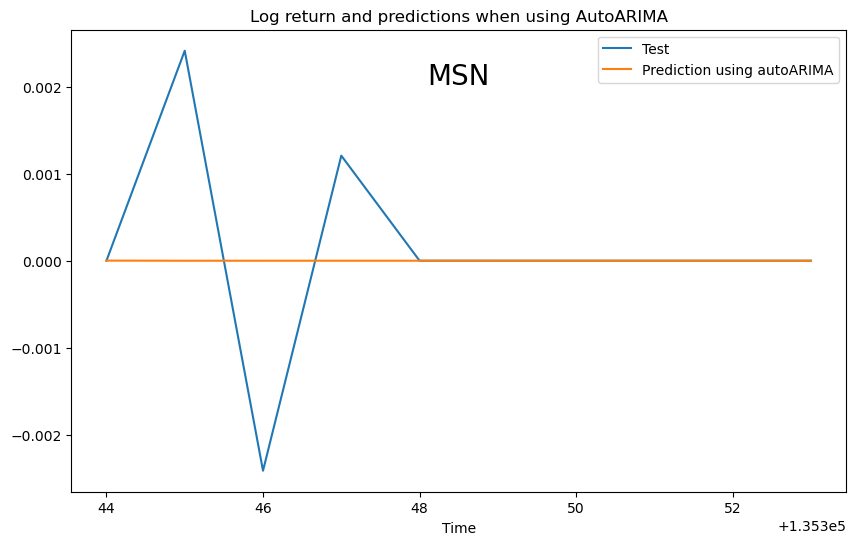

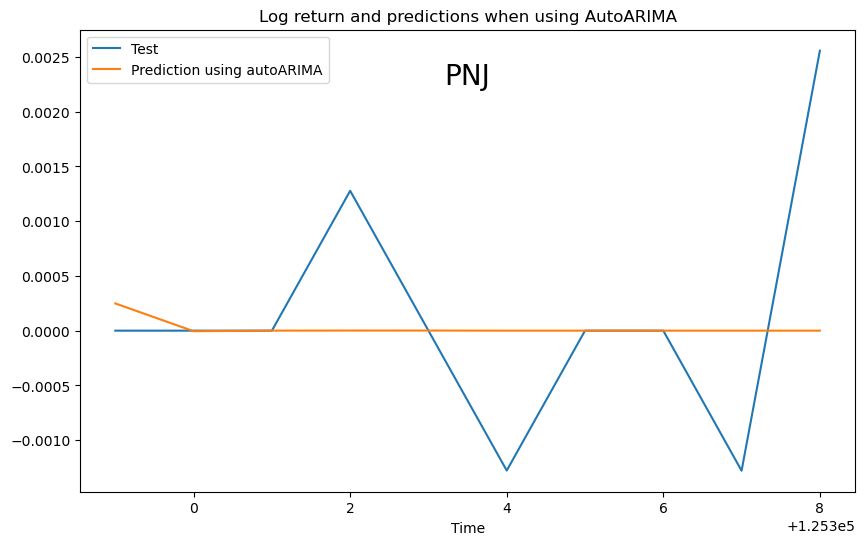

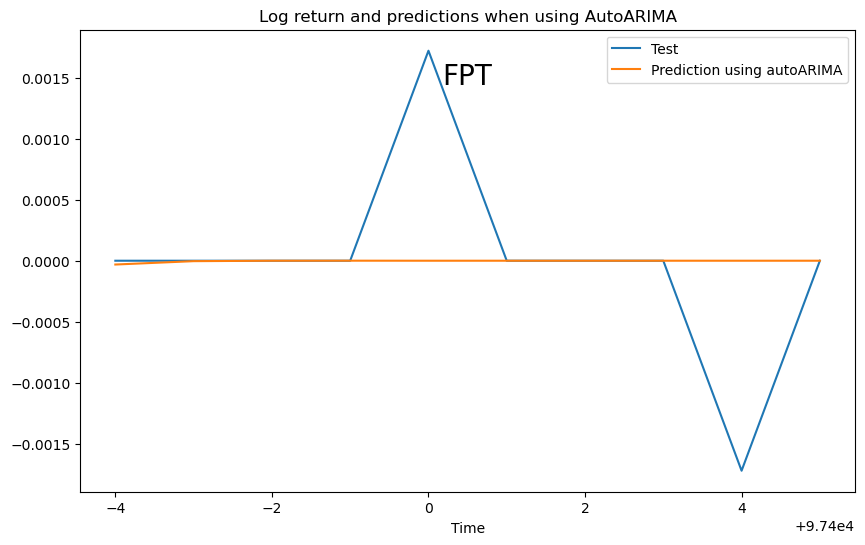

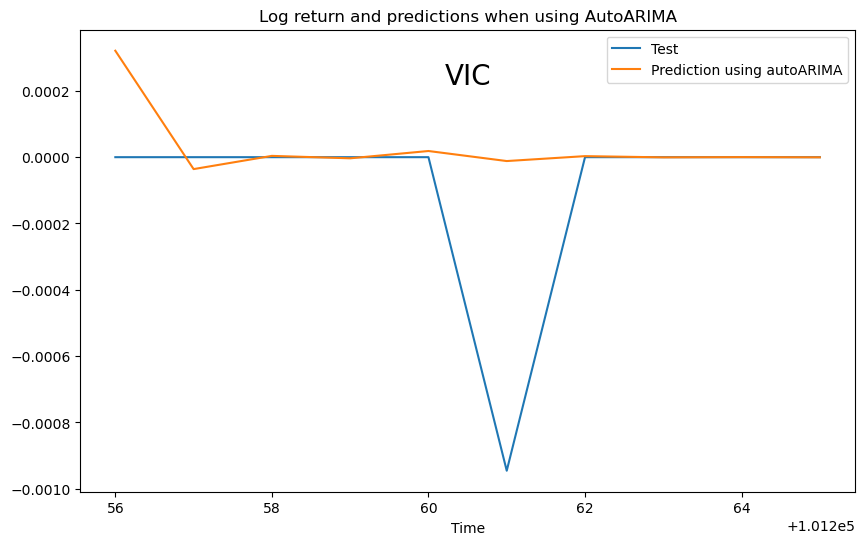

In [124]:
for var in variables:
    plt.figure(figsize = (10,6))
    plt.plot(globals()[var + "_test"].index, globals()[var + "_test"], label='Test')
    plt.plot(globals()[var + "_test"].index, globals()[var + "_autoARIMA_forecast_test"], label = "Prediction using autoARIMA")
    plt.title("Log return and predictions when using AutoARIMA")
    plt.xlabel("Time")
    plt.text(0.5, 0.9, var, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize = 20)   
    plt.legend()
    plt.show()

### 2.2.7 Step 7: Evaluate the model

Evaluating the model by

- Mean absolute error (MAE): It is measured as the average absolute difference between the predicted values and the actual values $MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y_i}|$

- Mean absolute percentage error (MAPE): $MAPE = \frac{1}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right|$

- Root Mean Square Error (RMSE): $RMSE = \sqrt{\sum_{i=1}^n \frac{(y_i - \hat{y}_i)^2}{n}}$

Therefore, **smaller values of MAE and RMSE indicate better predictive accuracy, while for MAPE, lower values indicate higher accuracy**.


In [120]:
for var in variables:
    globals()[var + "_ACF/PACF_MAE"] = mean_absolute_error(globals()[var + "_test"], globals()[var + "_ACF/PACF_forecast_test"])
    globals()[var + "_ACF/PACF_MAPE"] = mean_absolute_percentage_error(globals()[var + "_test"], globals()[var + "_ACF/PACF_forecast_test"])
    globals()[var + "_ACF/PACF_RMSE"] = mean_squared_error(globals()[var + "_test"], globals()[var + "_ACF/PACF_forecast_test"])
    
    print(f"{var} MAE (ACF/PACF): {globals()[var + '_ACF/PACF_MAE']}")
    print(f"{var} MAPE (ACF/PACF): {globals()[var + '_ACF/PACF_MAPE']}")
    print(f"{var} RMSE (ACF/PACF): {globals()[var + '_ACF/PACF_RMSE']}")
    print()    

MSN MAE (ACF/PACF): 0.0006059408064008258
MSN MAPE (ACF/PACF): 7892522671.733278
MSN RMSE (ACF/PACF): 1.3135382705405204e-06

PNJ MAE (ACF/PACF): 0.000666543917627423
PNJ MAPE (ACF/PACF): 135400052236.74057
PNJ RMSE (ACF/PACF): 1.1456392863949953e-06

FPT MAE (ACF/PACF): 0.00034922184692138365
FPT MAPE (ACF/PACF): 23795769728.38885
FPT RMSE (ACF/PACF): 5.915105896823248e-07

VIC MAE (ACF/PACF): 0.00014281136116573177
VIC MAPE (ACF/PACF): 227893069620.69342
VIC RMSE (ACF/PACF): 9.666513202542344e-08



In [121]:
for var in variables:
    globals()[var + "_AutoARIMA_MAE"] = mean_absolute_error(globals()[var + "_test"], globals()[var + "_autoARIMA_forecast_test"])
    globals()[var + "_AutoARIMA_MAPE"] = mean_absolute_percentage_error(globals()[var + "_test"], globals()[var + "_autoARIMA_forecast_test"])
    globals()[var + "_AutoARIMA_RMSE"] = mean_squared_error(globals()[var + "_test"], globals()[var + "_autoARIMA_forecast_test"])
    
    print(f"{var} MAE (AutoARIMA): {globals()[var + '_AutoARIMA_MAE']}")
    print(f"{var} MAPE (AutoARIMA): {globals()[var + '_AutoARIMA_MAPE']}")
    print(f"{var} RMSE (AutoARIMA): {globals()[var + '_AutoARIMA_RMSE']}")
    print()  

MSN MAE (AutoARIMA): 0.0006040927514675512
MSN MAPE (AutoARIMA): 647862593.5109518
MSN RMSE (AutoARIMA): 1.3129917917723652e-06

PNJ MAE (AutoARIMA): 0.0006647359593981175
PNJ MAPE (AutoARIMA): 114976512511.85788
PNJ RMSE (AutoARIMA): 1.1504103683408773e-06

FPT MAE (AutoARIMA): 0.00034744346397796115
FPT MAPE (AutoARIMA): 15786414057.942556
FPT RMSE (AutoARIMA): 5.915656957366843e-07

VIC MAE (AutoARIMA): 0.00013211644531794777
VIC MAPE (AutoARIMA): 174389634809.73495
VIC RMSE (AutoARIMA): 9.770020739800615e-08



**Note that:** Actual values close to zero: If there are actual values close to or very close to zero, this can result in a very large MAPE value. When dividing by very small values, the relative errors become extremely large, thus leading to a large MAPE.

## 3. SARIMA model

In [132]:
AirPassenger = pd.read_csv('AirPassengers.csv')
AirPassenger.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


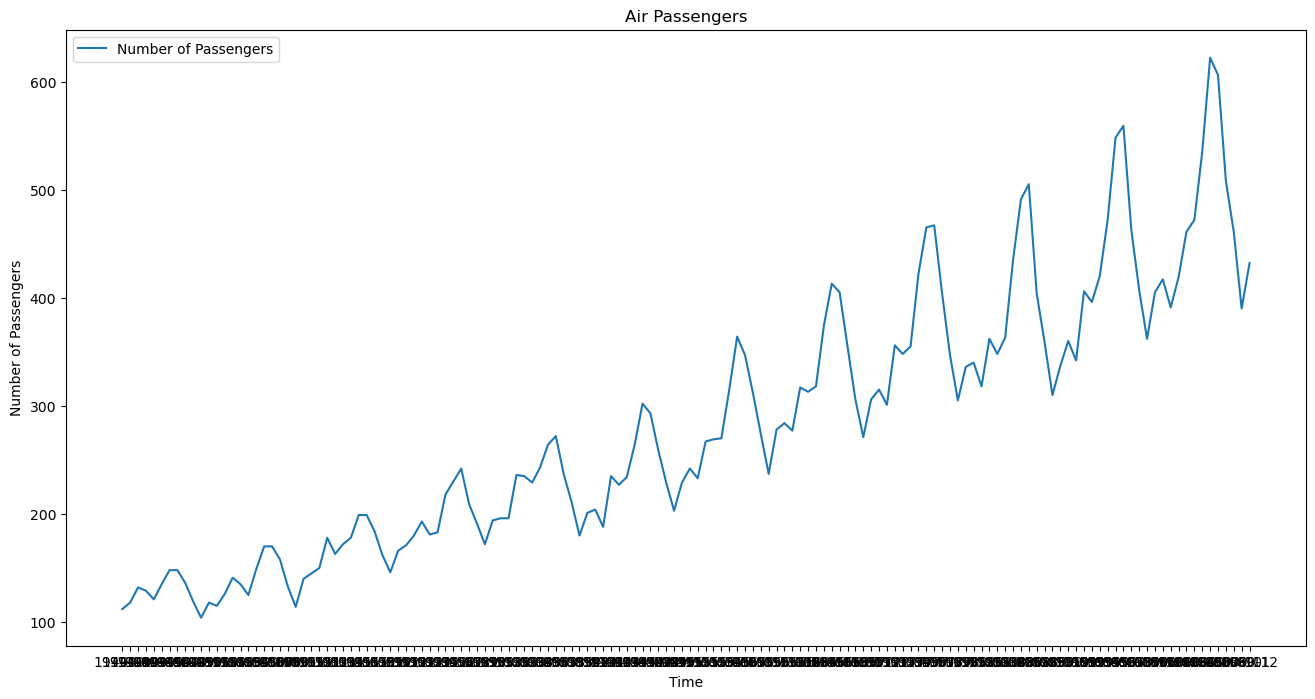

In [140]:
plt.figure (figsize = (16,8))
plt.plot(AirPassenger['Month'], AirPassenger['#Passengers'], label ='Number of Passengers')
plt.title("Air Passengers")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

In [141]:
AirPassenger = AirPassenger['#Passengers']

In [144]:
train_size = int(len(AirPassenger)*0.95)

train_passengers = AirPassenger.iloc[: train_size]
test_passengers = AirPassenger.iloc[train_size :]


136    472
137    535
138    622
139    606
140    508
141    461
142    390
143    432
Name: #Passengers, dtype: int64

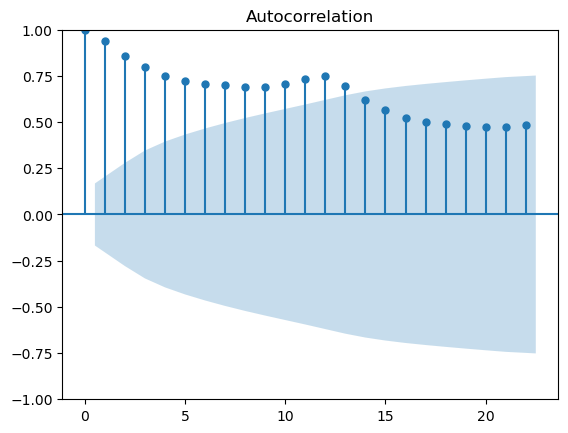

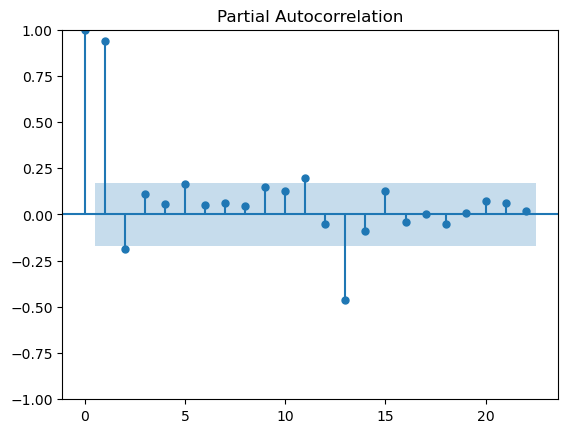

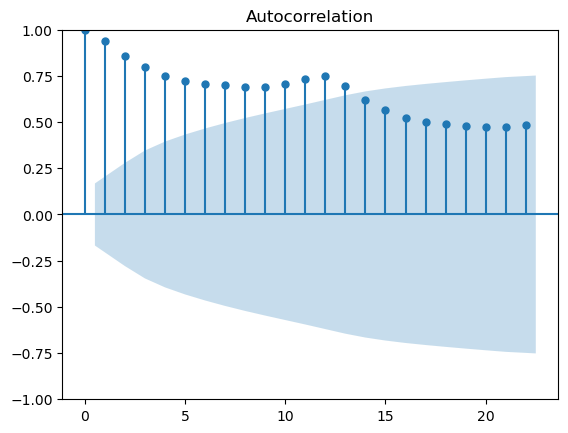

In [145]:
plot_pacf(train_passengers)
plot_acf(train_passengers)

In [158]:
model_sarima = pm.auto_arima(train_passengers,stepwise=True, seasonal=True)
print(model_sarima)

 ARIMA(2,1,2)(0,0,0)[0] intercept


In [160]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  136
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -622.164
Date:                Fri, 15 Mar 2024   AIC                           1256.328
Time:                        18:15:06   BIC                           1273.759
Sample:                             0   HQIC                          1263.411
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6472      0.197      3.288      0.001       0.261       1.033
ar.L1          1.6529      0.030     54.931      0.000       1.594       1.712
ar.L2         -0.9162      0.029    -32.124      0.000      -0.972      -0.860
ma.L1         -1.8475      0.043    -42.560      0.000      -1.933      -1.762
ma.L2          0.9402      0.044     21.483      0.000       0.854       1.026
sigma2       569.1950     66.531      8.555      0.000     438.797     699.593
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):                 1.95
Prob(Q):                              0.36   Prob(JB):                         0.38
Heteroskedasticity (H):               6.30   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
forecast_Auto_ARIMA = model_sarima.predict(len(test_passengers))
forecast_Auto_ARIMA

136    505.291408
137    534.771949
138    543.568420
139    531.745784
140    504.792320
141    471.720034
142    442.396540
143    424.875324
dtype: float64

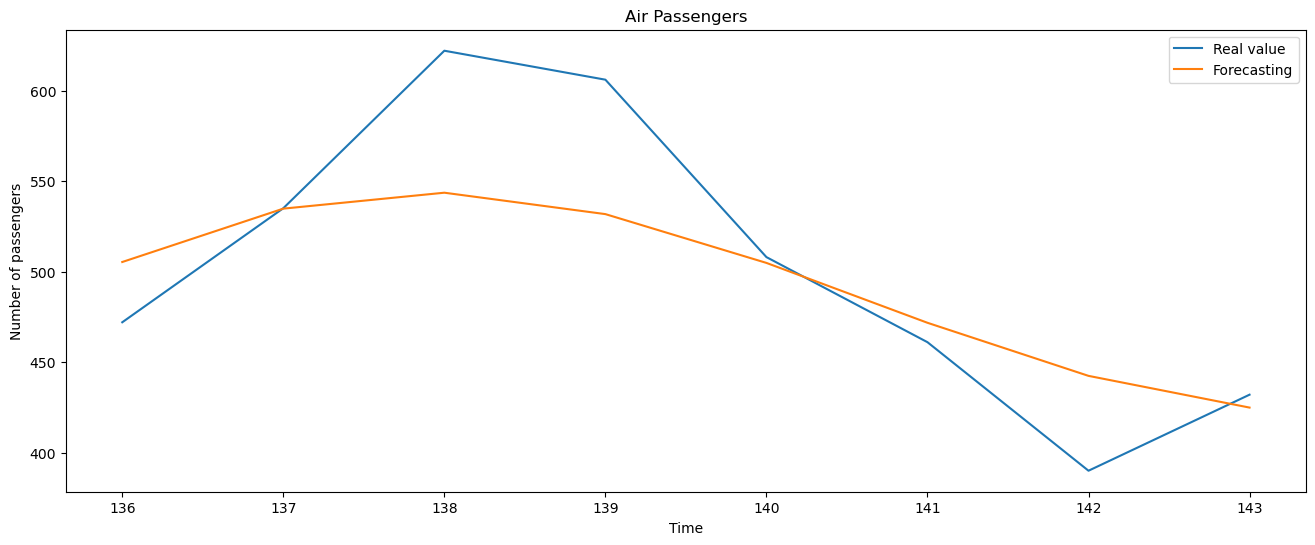

In [164]:
plt.figure(figsize = (16,6))
plt.plot(test_passengers.index, test_passengers, label = "Real value")
plt.plot(test_passengers.index, forecast_Auto_ARIMA, label= "Forecasting")
plt.title("Air Passengers")
plt.xlabel("Time")
plt.ylabel("Number of passengers")
plt.legend()
plt.show()

In [165]:
air_MAE = mean_absolute_error(test_passengers, forecast_Auto_ARIMA)
air_MAPE = mean_absolute_percentage_error(test_passengers, forecast_Auto_ARIMA)
air_RMSE = mean_squared_error(test_passengers, forecast_Auto_ARIMA)
    
print(f"MAE: {air_MAE}, RMSE: {air_RMSE}, RMSE: {air_RMSE}")

MAE: 32.45677329412349, RMSE: 1961.8672610835936, RMSE: 1961.8672610835936
